In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.interpolate

In [2]:
# set up original camera matrix
f = 300
K = np.diag([300, 300, 1])
K[0, 2] = f // 2
K[1, 2] = f // 2

C = np.array([0, 0, 0, 1])

P = K @ (np.hstack([np.eye(3), -(C[:3] / C[3]).reshape(-1, 1)]))
P

array([[300.,   0., 150.,   0.],
       [  0., 300., 150.,   0.],
       [  0.,   0.,   1.,   0.]])

In [67]:
# def generate_points(n, seed=0):
#    """Generate n random points in 3D space"""
#     np.random.seed(seed)
#     points = np.random.uniform(-1, 1, (n, 4))
#     points[:, 0] *= 2
#     points[:, 1] *= 2
#     points[:, 2] += 5
#     points[:, 3] = 1
#     return points

def generate_points(rows, cols):
    """Generate nxn grid of points in 3D space around Z axis"""
    center = np.array([0, 0, 5, 1])
    # make an n by n grid surrounding the center
    x = np.linspace(-0.1 * cols, 0.1 * cols, cols)
    y = np.linspace(-0.1 * rows, 0.1 * rows, rows)
    yy, xx = np.meshgrid(x, y)
    points = np.stack([xx, yy], axis=-1).reshape(-1, 2)
    points = np.hstack([points, np.zeros((rows * cols, 1)), np.ones((rows * cols, 1))])
    points += center
    return points

def get_rotated_camera(K, C, x=0, y=0, z=0):
    """Apply a rotation to a camera matrix"""
    R = np.eye(3)
    R = R @ cv2.Rodrigues(np.array([x, y, z]))[0]
    P = K @ np.hstack([R, -(C[:3] / C[3]).reshape(-1, 1)])
    return P

def get_normalizing_transform(X):
    """Get a normalizing transformation matrix for a set of identified points"""
    N = X.shape[0]

    # get centroid
    c_x = X[:, 0].mean()
    c_y = X[:, 1].mean()

    # get T
    denom = (np.sqrt((X[:, 0] - c_x) ** 2 + (X[:, 1] - c_y) ** 2 )).sum()
    s = N * 2 ** 0.5 / denom
    t_x = -s * c_x
    t_y = -s * c_y
    T = np.eye(3) * s
    T[:, 2] = np.array([t_x, t_y, 1])
    return T

# TODO: goal with homography: load an image and points such that the coordinates of the points line up with that on the image
# in A2, the image was in typical matrix format, from the top down (down, then right)
# the points were in cartesian coordinates, from the top down as well (right, then down)

# either make the image asap and dont deal with plt.scatter, or fix for plt.scatter
def get_homography(X1, X2):
    """Get the homography matrix that maps X1 to X2"""
    # get normalizing transformation matrices
    T1 = get_normalizing_transform(X1)
    T2 = get_normalizing_transform(X2)

    n = X1.shape[0]

    # normalize each matrix
    X1n = np.hstack([X1, np.ones((n, 1))]) @ T1.T
    X2n = np.hstack([X2, np.ones((n, 1))]) @ T2.T

    # build A
    A = np.array([]).reshape(0, 9)
    for i in range(n):
        xip, yip, wip = X2n[i, :]
        xi = X1n[i, :].reshape(1, 3)
        row1 = np.hstack([np.zeros((1, 3)), -wip* xi, yip * xi])
        row2 = np.hstack([wip * xi, np.zeros((1, 3)), -xip * xi])
        A = np.vstack([A, row1, row2])

    # solve for homography in normalized coordinates
    _, _, V = np.linalg.svd(A)
    Hn = V[8, :].reshape(3, 3)

    # undo normalize transformation
    H = np.linalg.inv(T2) @ Hn @ T1
    return H

def apply_homography(Iin, H):
    """Apply a homography to a full image"""
    # Input points are given in cartesian coordinates (col-first),
    # so we account for this (because H is already affected).
    # The dimension order now goes n by m for cartesian coordinates
    m, n = Iin.shape[:2]

    # find bounds of image, then build mesh in rectified space
    I_corners = np.array([[0, 0], [0, m - 1], [n - 1, 0], [n - 1, m - 1]])
    Iph_corners = np.hstack([I_corners, np.ones((4, 1))]) @ H.T
    Ip_corners = Iph_corners[:, :2] / Iph_corners[:, 2:]
    xmin, ymin = Ip_corners.min(axis=0)
    xmax, ymax = Ip_corners.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, n), np.linspace(ymin, ymax, m))
    Xp = np.vstack([x.flatten(), y.flatten(), np.ones(m * n)]).T

    # find corresponding points in the original space by solving the equation
    # X^T = H^-1 @ X'^T  ->  H @ X^T = X'^T
    Xh = np.linalg.lstsq(H, Xp.T, rcond=None)[0].T
    X = Xh[:, :2] / Xh[:, 2:]

    # Isolate each color channel and interpolate the color value
    # at the coordinates listed in X. Single-channel image I still uses
    # row-first coordinates, so we flip X when interpolating
    res = np.zeros((m, n, 3))
    for i in range(3):
        I = Iin[:, :, i]
        interpolator = scipy.interpolate.RegularGridInterpolator(
            (np.arange(I.shape[0]), np.arange(I.shape[1])),
            I,
            bounds_error=False,
            fill_value=0
        )
        Ip = interpolator(X[:, ::-1]).reshape(m, n) / 255
        res[:, :, i] = Ip
    return res

In [71]:
def points_to_image(points2d, h=300, w=300, r=5):
    """Convenience function that converts matplotlib points to an image"""
    arr = np.ones((h, w, 3))
    for i in range(h):
        for j in range(w):
            # check if pixel is within r of any point
            for k in range(points2d.shape[0]):
                point = points2d[k, :]
                if np.linalg.norm(np.array([i, j]) - point) < r:
                    if k == 0:
                        arr[i, j] = np.array([1, 0, 0])
                    elif k == 1:
                        arr[i, j] = np.array([0, 1, 0])
                    else:
                        arr[i, j] = np.array([0, 0, 1])
                    break
    return arr

def plot_points_as_image(*points2d):
    """Plot points with same coordinate system as plt.imshow (inverted y axis, row-first)"""
    n = len(points2d)
    fig = plt.figure(figsize=(5 * n, 5))
    for i in range(n):
        points = points2d[i]
        ax = fig.add_subplot(1, n, i + 1)
        ax.scatter(points[:, 1], points[:, 0])
        ax.scatter([points[0, 1]], [points[0, 0]], c='r')
        ax.scatter([points[1, 1]], [points[1, 0]], c='g')
        ax.set_aspect('equal')
        ax.set_xlim(0, 300)
        ax.set_ylim(300, 0)
    plt.show()

In [72]:
P_30z = get_rotated_camera(K, C, z=np.pi/6)
P_30z

array([[ 259.80762114, -150.        ,  150.        ,    0.        ],
       [ 150.        ,  259.80762114,  150.        ,    0.        ],
       [   0.        ,    0.        ,    1.        ,    0.        ]])

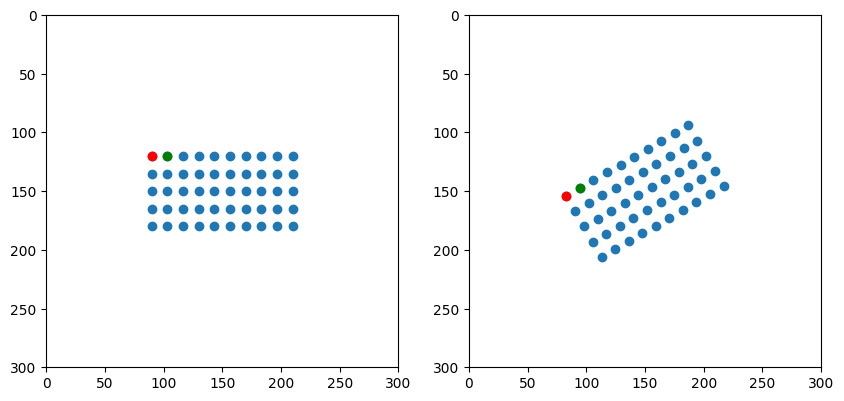

In [73]:
# x left-right, y top-bottom, z near-far

# orig starts bottom-up, left-right
# rotation via image correctly goes 30 deg clockwise, based on z axis
# with matplotlib, first column is x (left-right), second is y (bottom-up)

# when working with creating the image, we need to flip the y axis, and make sure that the axis order is correct (ij does top-down, left-right)
points_3dh = generate_points(5, 10)
points_2dh_orig = points_3dh @ P.T
points_2d_orig = points_2dh_orig[:, :2] / points_2dh_orig[:, 2].reshape(-1, 1)

points_2dh_30z = points_3dh @ P_30z.T
points_2d_30z = points_2dh_30z[:, :2] / points_2dh_30z[:, 2].reshape(-1, 1)

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# for ax in axs:
#     ax.set_xlim(0, f)
#     ax.set_ylim(0, f)
#     ax.set_aspect('equal')

# axs[0].scatter(points_2d_orig[:, 0], points_2d_orig[:, 1])
# axs[1].scatter(points_2d_30z[:, 0], points_2d_30z[:, 1])

plot_points_as_image(points_2d_orig, points_2d_30z)

In [51]:
H = get_homography(points_2d_orig, points_2d_30z)
H

array([[-5.00000000e-01,  2.88675135e-01, -5.49038106e+01],
       [-2.88675135e-01, -5.00000000e-01,  3.16987298e+01],
       [ 4.60958588e-19,  4.04970850e-19, -5.77350269e-01]])

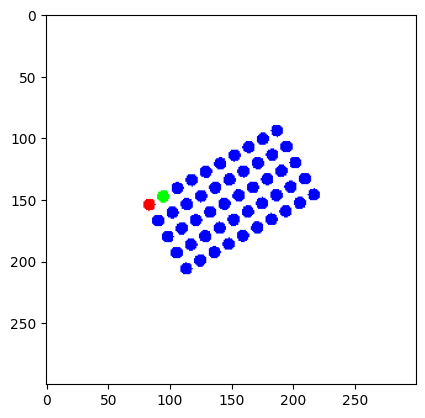

In [75]:
temp = points_to_image(points_2d_30z)
plt.imshow(temp)